In [6]:
import torch
from utils import save_checkpoint, load_checkpoint, save_some_examples
from tqdm import tqdm
from dataset import MapDataset
from torch.utils.data import DataLoader
from generator import Generator
from discriminator import Discriminator
import torch.nn as nn
import torch.optim as optim
import config

import matplotlib.pyplot as plt

In [7]:
# Creamos el discriminador y el generador
disc = Discriminator(in_channels=3).to(config.DEVICE)
gen = Generator(in_channels=3).to(config.DEVICE)
# Creamos los optimizadores
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

In [8]:
if config.LOAD_MODEL:
    # Cargamos los pesos del generador
    load_checkpoint(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,)
    # Cargamos los pesos del discriminador
    load_checkpoint(config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE,)

# Cargamos el dataset
train_dataset = MapDataset(root_dir=config.TRAIN_DIR)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)

=> Loading checkpoint
=> Loading checkpoint


In [32]:
def denormalize_image(norm_image):
    # Revertimos la normalización
    denorm_image = (norm_image * 0.5) + 0.5
    return denorm_image

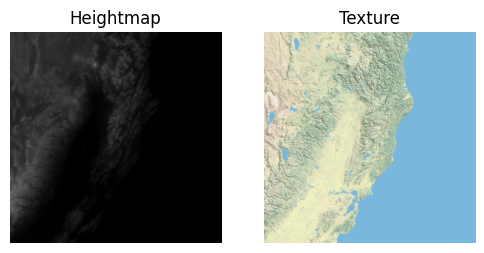

In [45]:
def show_images(dataset, index):
    heightmap, texture = dataset[index]

    # Convertimos a numpy
    heightmap = heightmap.permute(1, 2, 0).numpy()
    heightmap = denormalize_image(heightmap)
    texture = texture.permute(1, 2, 0).numpy()
    texture = denormalize_image(texture)
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(heightmap)
    axes[0].set_title('Heightmap')
    axes[0].axis('off')

    axes[1].imshow(texture)
    axes[1].set_title('Texture')
    axes[1].axis('off')

    plt.show()

N = 0
show_images(train_dataset, N)

In [ ]:
### Entrenamiento
from train import train_fn

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

val_dataset = MapDataset(root_dir=config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

for epoch in range(config.NUM_EPOCHS):
    train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

    if config.SAVE_MODEL:
        save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)

    save_some_examples(gen, val_loader, epoch, folder="evaluation")

In [2]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision.utils import save_image
import config

def infer_and_save_example(gen, img_path, output_folder, device):
    # Cargar imágenes
    input_image = np.array(Image.open(img_path))

    # Convertir a 3 canales si es necesario
    if len(input_image.shape) == 2 or input_image.shape[2] == 1:
        input_image = np.stack((input_image,) * 3, axis=-1)

    # Normalizar imagen
    input_image = (input_image / 65535.0 * 255).astype(np.uint8)

    # Aplicar transformaciones
    augmentations = config.both_transform(image=input_image)
    input_image = augmentations["image"]
    input_image = config.transform_only_input(image=input_image)["image"]

    # Enviar a GPU
    input_tensor = input_image.unsqueeze(0).to(device)

    # Inferencia
    gen.eval()
    with torch.no_grad():
        output = gen(input_tensor)
        output = (output * 0.5 + 0.5).clamp(0, 1)

    # Guardar imagen generada
    save_image(output, f"{output_folder}/output_{0}.png")

    gen.train()


In [ ]:
from utils import load_checkpoint
from generator import Generator
from discriminator import Discriminator
import config
import torch.nn as nn
import torch.optim as optim

disc = Discriminator(in_channels=3).to(config.DEVICE)
gen = Generator(in_channels=3).to(config.DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

load_checkpoint(
    config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
)
load_checkpoint(
    config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE,
)

image_path = r"path/to/image.png"
output_folder = "inference"
infer_and_save_example(gen, image_path, output_folder, config.DEVICE)
